In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
from bs4 import BeautifulSoup
import string,unicodedata
from sklearn.feature_extraction.text import CountVectorizer
from plotly.subplots import make_subplots
import plotly.graph_objects as go


In [22]:
df = pd.read_csv("/content/Israel Palestine Reddit Scrape.csv")

In [23]:
df.head()

,body,category,communityName,createdAt,dataType,description,flair,html,id,isAd,...,scrapedAt,thumbnailUrl,title,upVoteRatio,upVotes,url,userIcon,userId,username,videoUrl
0,NaN,NaN,NaN,2020-12-25T10:05:46.000Z,user,fuck israel fuck palestine,NaN,NaN,9hoyx9ic,NaN,...,2024-06-18T15:16:41.800Z,NaN,NaN,NaN,NaN,https://www.reddit.com/user/Frost_boi/,https://i.redd.it/snoovatar/avatars/1ff35ee1-1...,NaN,Frost_boi,NaN
1,NaN,NaN,NaN,2021-02-01T20:45:28.000Z,user,i hate a levels,NaN,NaN,8qr8j0iq,NaN,...,2024-06-18T15:16:41.846Z,NaN,NaN,NaN,NaN,https://www.reddit.com/user/420koolaidman/,https://styles.redditmedia.com/t5_3vnvw8/style...,NaN,420koolaidman,NaN
2,URL: https://v.redd.it/qetvjinh7zsb1\nThumbnai...,NaN,r/TikTokCringe,2023-10-08T12:55:20.000Z,post,NaN,Discussion,NaN,t3_172yh7w,False,...,2024-06-18T15:16:46.873Z,nsfw,Having a nuanced view of the Israel Palestine ...,0.83,6284.0,https://www.reddit.com/r/TikTokCringe/comments...,NaN,t2_geo60,BryanAbbo,https://v.redd.it/qetvjinh7zsb1/DASH_480.mp4?s...
3,For the past decade or so I have typically sup...,NaN,r/IsraelPalestine,2023-10-08T10:51:36.000Z,post,NaN,2023.10.7 Hamas Operation Al-Aqsa Flood/IDF Ir...,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",t3_172w9gt,False,...,2024-06-18T15:16:47.675Z,self,I have changed my mind about the Israel-Palest...,0.67,4886.0,https://www.reddit.com/r/IsraelPalestine/comme...,NaN,t2_a8375x5n,Buy_Ether,NaN
4,Both claim to be the descendants of Abraham th...,TikTokCringe,r/TikTokCringe,2023-10-08T14:58:09.000Z,comment,NaN,NaN,"&lt;div class=""md""&gt;&lt;p&gt;Both claim to b...",t1_k3zup0l,NaN,...,2024-06-18T15:16:53.558Z,NaN,NaN,NaN,5.0,https://www.reddit.com/r/TikTokCringe/comments...,NaN,t2_3q7hyl88,notasuccessstory,NaN


Data Processing


In [26]:
df = df.iloc[:, :1]

In [27]:
df.head()

,body
0,NaN
1,NaN
2,URL: https://v.redd.it/qetvjinh7zsb1\nThumbnai...
3,For the past decade or so I have typically sup...
4,Both claim to be the descendants of Abraham th...


In [28]:
# Handling missing values
df = df.dropna()

In [29]:
df.head()

,body
2,URL: https://v.redd.it/qetvjinh7zsb1\nThumbnai...
3,For the past decade or so I have typically sup...
4,Both claim to be the descendants of Abraham th...
5,"If that’s the case, then his Native American c..."
6,May not be the best analogy but racism kept Je...


In [30]:
mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot",
           "'cause": "because", "could've": "could have", "couldn't": "could not",
           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
           "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will",
           "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will",
           "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will",
           "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have",
           "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
           "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not",
           "might've": "might have","mightn't": "might not","mightn't've": "might not have",
           "must've": "must have", "mustn't": "must not", "mustn't've": "must not have",
           "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
           "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would",
           "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
           "she's": "she is", "should've": "should have", "shouldn't": "should not",
           "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is",
           "that'd": "that would", "that'd've": "that would have", "that's": "that is",
           "there'd": "there would", "there'd've": "there would have", "there's": "there is",
           "here's": "here is","they'd": "they would", "they'd've": "they would have",
           "they'll": "they will", "they'll've": "they will have", "they're": "they are",
           "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would",
           "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
           "we're": "we are", "we've": "we have", "weren't": "were not",
           "what'll": "what will", "what'll've": "what will have","what're": "what are",
           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have",
           "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
           "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is",
           "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
           "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
           "y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
           "you're": "you are", "you've": "you have" }

In [31]:
# Function to remove HTMl tags
def remove_html_tags(text):
  soup=BeautifulSoup(text, "html.parser")
  return soup.get_text()

# Assuming Processed Reddit is the column with HTML content
df['Clean body'] = df['body'].apply(remove_html_tags)

<ipython-input-31-34f7a9b0340c>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup=BeautifulSoup(text, "html.parser")
<ipython-input-31-34f7a9b0340c>:3: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup=BeautifulSoup(text, "html.parser")


In [32]:
# Remove URLs and Special characters with Regular Expressions
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URL
    text = re.sub(r'\S*@\S*\s?', '', text)  # Remove mailboxes
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")]) #expanding chatwords and contracts clearing contractions
    emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_clean.sub(r'',text)
    return text

df['Clean body'] = df['Clean body'].apply(clean_text)

In [33]:
df['Clean body']

2                     URL \nThumbnail nsfw\nImages\n\t\n
3      For the past decade or so I have typically sup...
4      Both claim to be the descendants of Abraham th...
5      If thats the case then his Native American com...
6      May not be the best analogy but racism kept Je...
                             ...                        
497     Fuck\n\nuDarkChoomba Please avoid using profa...
498    Supporting Palestinian self determination and ...
499    Tally up the death tolls from 1947 to now deat...
500                                                   No
501    100 agreed i used to think Israel was an oppre...
Name: Clean body, Length: 500, dtype: object

In [34]:
# Convert datetime stringd to Python datetime objects, drop 'scrapedAt'
#df['createdAt'] = pd.to_datetime(df['createdAt'], utc=True)
#df = df.drop(columns = ['scrapedAt'])

KeyError: 'createdAt'

In [35]:
# Text preprocessing using NLTK or spaCy: word splitting, deletion of stop words, word shape reduction
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download the necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [36]:
stopwords = nltk.corpus.stopwords.words('english')
Clean_text = [word for word in df if word.lower() not in stopwords]


In [39]:
lemmatizer = WordNetLemmatizer()

In [49]:
# of pre-processed text
def preprocess_text(df):
    text = df.lower()
    words = df.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords]
    return ' '.join(words)

df['Processed body'] = df['Clean body'].apply(preprocess_text)
df['Processed body']

2                              URL Thumbnail nsfw Images
3      For past decade I typically supported Palestin...
4      Both claim descendant Abraham though So wouldn...
5      If thats case Native American comment make zer...
6      May best analogy racism kept Jews finding new ...
                             ...                        
497    Fuck uDarkChoomba Please avoid using profanity...
498    Supporting Palestinian self determination oppo...
499    Tally death toll 1947 death child especially P...
500                                                   No
501    100 agreed used think Israel oppressive Aparth...
Name: Processed body, Length: 500, dtype: object

In [50]:
df.to_csv('Processed_dataset_withsentiment.csv', index=False)

Text Analysis


Length

In [24]:
#post_word_counts = df[df['dataType'] == 'post']['Processed body'].apply(lambda x: len(str(x).split()))
#comment_word_counts = df[df['dataType'] == 'comment']['Processed body'].apply(lambda x: len(str(x).split()))
#title_word_counts = df['title'].dropna().apply(lambda x: len(str(x).split()))

#print("Post Length Statistics:\n", post_word_counts.describe())
#print("\nComment Length Statistics:\n", comment_word_counts.describe())
#print("\nTitle Length Statistics:\n", title_word_counts.describe())

Post Length Statistics:
 count       0
unique      0
top       NaN
freq      NaN
Name: Processed body, dtype: object

Comment Length Statistics:
 count       0
unique      0
top       NaN
freq      NaN
Name: Processed body, dtype: object

Title Length Statistics:
 count       0
unique      0
top       NaN
freq      NaN
Name: title, dtype: object


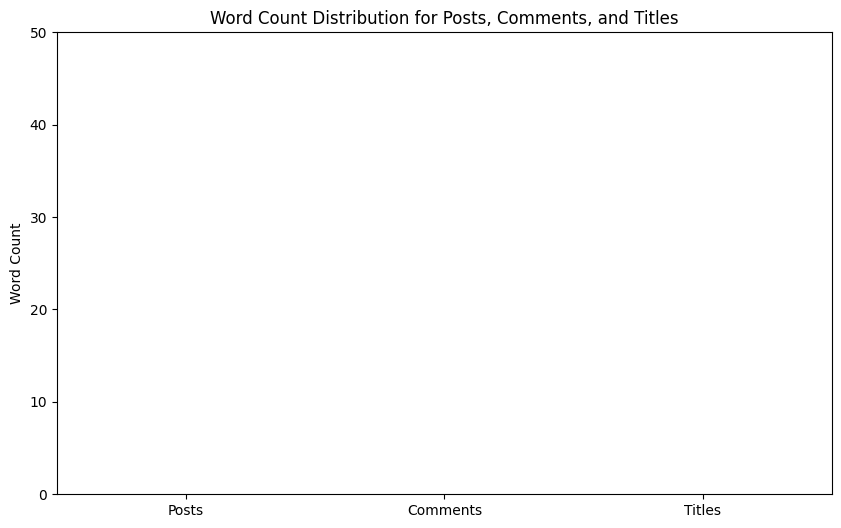

In [ ]:
#data = [post_word_counts, comment_word_counts, title_word_counts]

#plt.figure(figsize=(10, 6))
#plt.boxplot(data, labels=['Posts', 'Comments', 'Titles'], showmeans=True, meanline=True)

#plt.ylim(0, 50)

#plt.title('Word Count Distribution for Posts, Comments, and Titles')
#plt.ylabel('Word Count')

#plt.show()

Keyword Extraction

In [51]:
# Extract keywords using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(df['Processed body'])
tfidf

<500x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 6792 stored elements in Compressed Sparse Row format>

In [52]:
# # Example preprocessing function (adjust as needed)
# def preprocess_text(text):
#     # Lowercase
#     text = text.lower()
#     # Tokenize
#     words = nltk.word_tokenize(text)
#     # Remove stopwords
#     words = [word for word in words if word not in stopwords]
#     # Lemmatize
#     words = [lemmatizer.lemmatize(word) for word in words]
#     return ' '.join(words)

# # Apply preprocessing to your dataframe
# df['Processed body'] = df['body'].apply(preprocess_text)

# # Check the content of Processed body
# print(df['Processed body'].head())

# # Now, use TfidfVectorizer
# from sklearn.feature_extraction.text import TfidfVectorizer

# # Define the TfidfVectorizer
# tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')

# # Fit and transform the data
# try:
#     tfidf = tfidf_vectorizer.fit_transform(df['Processed body'])
#     print(tfidf)
# except ValueError as e:
#     print("Error:", e)
#     print("Please check the content of 'Processed body' for issues.")

# # Output the features to check if vocabulary is created
# print(tfidf_vectorizer.get_feature_names_out())


LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/PY3/english.pickle[0m

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - ''
**********************************************************************


In [53]:
# Convert to array and get feature names (vocabulary)
feature_array = tfidf_vectorizer.get_feature_names_out()
tfidf_sorting = tfidf.toarray().argsort()[:, ::-1]

# Get the first N keywords of each document
n = 3
top_n_keywords = feature_array[tfidf_sorting][:,:n]
top_n_keywords

array([['zero', 'extremist', 'feel'],
       ['people', 'today', 'innocent'],
       ['historian', 'wouldnt', 'descendant'],
       ...,
       ['death', '1947', 'order'],
       ['zero', 'extremist', 'feel'],
       ['apartheid', 'state', 'think']], dtype=object)

Sentiment Analysis

In [55]:
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [56]:
# Sentiment analysis using VADER
sid = SentimentIntensityAnalyzer()
df['Sentiments'] = df['Processed body'].apply(lambda x: sid.polarity_scores(x))

In [57]:
df['Sentiments']

2      {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
3      {'neg': 0.215, 'neu': 0.658, 'pos': 0.127, 'co...
4      {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
5      {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
6      {'neg': 0.326, 'neu': 0.407, 'pos': 0.267, 'co...
                             ...                        
497    {'neg': 0.217, 'neu': 0.608, 'pos': 0.175, 'co...
498    {'neg': 0.179, 'neu': 0.539, 'pos': 0.282, 'co...
499    {'neg': 0.399, 'neu': 0.468, 'pos': 0.133, 'co...
500    {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...
501    {'neg': 0.353, 'neu': 0.55, 'pos': 0.096, 'com...
Name: Sentiments, Length: 500, dtype: object

In [58]:
# VADER Sentiment analysis categorisation
def classify_sentiment_vader(scores):
    if scores['compound'] >= 0.05:
        return 'positive'
    elif scores['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['VADER Sentiment'] = df['Sentiments'].apply(classify_sentiment_vader)
df['VADER Sentiment']

2       neutral
3      negative
4       neutral
5       neutral
6      negative
         ...   
497    negative
498    positive
499    negative
500    negative
501    negative
Name: VADER Sentiment, Length: 500, dtype: object

In [59]:
# Sentiment analysis using TextBlob (alternative)
df['TextBlob Sentiment'] = df['Processed body'].apply(lambda x: TextBlob(x).sentiment.polarity)
def classify_sentiment_textblob(score):
    if score > 0:
        return 'positive'
    elif score < 0:
        return 'negative'
    else:
        return 'neutral'

df['TextBlob Sentiment Category'] = df['TextBlob Sentiment'].apply(classify_sentiment_textblob)
df['TextBlob Sentiment Category']

2       neutral
3      negative
4      positive
5       neutral
6      positive
         ...   
497    negative
498    negative
499    positive
500     neutral
501     neutral
Name: TextBlob Sentiment Category, Length: 500, dtype: object

In [60]:
df.head()

,body,Clean body,Processed body,Sentiments,VADER Sentiment,TextBlob Sentiment,TextBlob Sentiment Category
2,URL: https://v.redd.it/qetvjinh7zsb1\nThumbnai...,URL \nThumbnail nsfw\nImages\n\t\n,URL Thumbnail nsfw Images,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,0.000000,neutral
3,For the past decade or so I have typically sup...,For the past decade or so I have typically sup...,For past decade I typically supported Palestin...,"{'neg': 0.215, 'neu': 0.658, 'pos': 0.127, 'co...",negative,-0.046088,negative
4,Both claim to be the descendants of Abraham th...,Both claim to be the descendants of Abraham th...,Both claim descendant Abraham though So wouldn...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,0.093750,positive
5,"If that’s the case, then his Native American c...",If thats the case then his Native American com...,If thats case Native American comment make zer...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,0.000000,neutral
6,May not be the best analogy but racism kept Je...,May not be the best analogy but racism kept Je...,May best analogy racism kept Jews finding new ...,"{'neg': 0.326, 'neu': 0.407, 'pos': 0.267, 'co...",negative,0.148377,positive


In [61]:
df.to_csv('Processed_dataset_withsentiment.csv', index = False)

In [62]:
posts = df[df['dataType'] == 'post']['TextBlob Sentiment Category']
comments = df[df['dataType'] == 'comment']['TextBlob Sentiment Category']

posts_value_counts = posts.value_counts().sort_index()
comments_value_counts = comments.value_counts().sort_index()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
posts_value_counts.plot(kind='bar', color='skyblue', title='Posts Sentiment Distribution')

plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.subplot(1, 2, 2)
comments_value_counts.plot(kind='bar', color='lightgreen', title='Comments Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

KeyError: 'dataType'

Topic Modeling

In [64]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [65]:
from collections import defaultdict
texts = [word_tokenize(doc) for doc in df['Processed body'] if word_tokenize(doc)]
# Remove very low-frequency words
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [[token for token in text if frequency[token] > 1] for text in texts]

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

ldamodel = LdaModel(corpus, num_topics=10, id2word=dictionary, passes=15)

In [66]:
topics = ldamodel.print_topics(num_words=2)
for topic in topics:
    print(topic)

(0, '0.030*"I" + 0.025*"removed"')
(1, '0.029*"I" + 0.016*"Israel"')
(2, '0.026*"Israel" + 0.022*"deleted"')
(3, '0.025*"people" + 0.022*"Hamas"')
(4, '0.030*"I" + 0.023*"side"')
(5, '0.018*"Palestine" + 0.017*"Israel"')
(6, '0.035*"argument" + 0.032*"debate"')
(7, '0.034*"I" + 0.029*"Please"')
(8, '0.018*"I" + 0.014*"The"')
(9, '0.018*"Israel" + 0.015*"people"')


In [67]:
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.030*"I" + 0.025*"removed" + 0.021*"comment" + 0.018*"civilian" + 0.012*"Palestinians"')
(1, '0.029*"I" + 0.016*"Israel" + 0.016*"Jews" + 0.013*"think" + 0.012*"dont"')
(2, '0.026*"Israel" + 0.022*"deleted" + 0.019*"people" + 0.013*"Jews" + 0.013*"Jewish"')
(3, '0.025*"people" + 0.022*"Hamas" + 0.019*"Israel" + 0.016*"I" + 0.014*"one"')
(4, '0.030*"I" + 0.023*"side" + 0.020*"Israel" + 0.016*"people" + 0.014*"civilian"')
(5, '0.018*"Palestine" + 0.017*"Israel" + 0.016*"year" + 0.010*"Jews" + 0.010*"Israeli"')
(6, '0.035*"argument" + 0.032*"debate" + 0.020*"group" + 0.017*"rule" + 0.016*"negative"')
(7, '0.034*"I" + 0.029*"Please" + 0.017*"bot" + 0.016*"question" + 0.016*"using"')
(8, '0.018*"I" + 0.014*"The" + 0.012*"Hamas" + 0.010*"Israel" + 0.009*"life"')
(9, '0.018*"Israel" + 0.015*"people" + 0.015*"Palestinians" + 0.013*"You" + 0.012*"need"')


In [69]:
pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 14.1 MB/s eta 0:00:00


In [70]:
# Lets visualize the topics
import pyLDAvis
from pyLDAvis.gensim import prepare

pyLDAvis.enable_notebook()
vis = prepare(ldamodel, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.064503  0.052310       1        1  15.441818
7     -0.028717 -0.236708       2        1  14.588662
3     -0.076262  0.049569       3        1  13.651415
9     -0.023025  0.049801       4        1  11.797011
6      0.341264  0.017426       5        1   8.920220
8     -0.042789  0.049556       6        1   8.784079
1     -0.052766  0.029759       7        1   7.280718
5     -0.026045  0.020520       8        1   7.172096
0     -0.007603 -0.070996       9        1   6.897301
2     -0.019555  0.038762      10        1   5.466680, topic_info=         Term        Freq       Total Category  logprob  loglift
211    Please   44.000000   44.000000  Default  30.0000  30.0000
838  argument   34.000000   34.000000  Default  29.0000  29.0000
879    debate   30.000000   30.000000  Default  28.0000  28.0000
4           I  189.000000  189.000000  Default  27.0000  27.0000
488   removed   22.000000   22.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
9        This    3.416462   54.606398  Topic10  -5.0942   0.1350
4           I    3.949913  189.875216  Topic10  -4.9491  -0.9662
81       make    3.151895   51.737028  Topic10  -5.1748   0.1083
105       The    2.915428   60.488560  Topic10  -5.2527  -0.1259
463     wrong    2.624597   17.728666  Topic10  -5.3578   0.9962

[673 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1291      2  0.848846          0
869       5  0.773191          1
869      10  0.193298          1
1199      8  0.778662       1923
773       2  0.939148          2
...     ...       ...        ...
349       8  0.231982       year
349      10  0.042179       year
493       4  0.231379  yesterday
493       8  0.462758  yesterday
555       7  0.784097      young

[1486 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 8, 4, 10, 7, 9, 2, 6, 1, 3])

In [74]:
len(df)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


500

In [73]:
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,body,Clean body,Processed body,Sentiments,VADER Sentiment,TextBlob Sentiment,TextBlob Sentiment Category
2,URL: https://v.redd.it/qetvjinh7zsb1\nThumbnai...,URL \nThumbnail nsfw\nImages\n\t\n,URL Thumbnail nsfw Images,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,0.000000,neutral
3,For the past decade or so I have typically sup...,For the past decade or so I have typically sup...,For past decade I typically supported Palestin...,"{'neg': 0.215, 'neu': 0.658, 'pos': 0.127, 'co...",negative,-0.046088,negative
4,Both claim to be the descendants of Abraham th...,Both claim to be the descendants of Abraham th...,Both claim descendant Abraham though So wouldn...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,0.093750,positive
5,"If that’s the case, then his Native American c...",If thats the case then his Native American com...,If thats case Native American comment make zer...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,0.000000,neutral
6,May not be the best analogy but racism kept Je...,May not be the best analogy but racism kept Je...,May best analogy racism kept Jews finding new ...,"{'neg': 0.326, 'neu': 0.407, 'pos': 0.267, 'co...",negative,0.148377,positive


In [80]:
df.drop(df.tail(2).index,
        inplace = True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [83]:
# Assume you already have a DataFrame containing documents, their most relevant topics, and sentiment scores
# We can get the most likely topic for each document through the LDA model
document_topics = [ldamodel[corpus[i]] for i in range(len(df))]
df['Dominant_Topic'] = [sorted(topics, key=lambda x: -x[1])[0][0] for topics in document_topics]

df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,body,Clean body,Processed body,Sentiments,VADER Sentiment,TextBlob Sentiment,TextBlob Sentiment Category,Dominant_Topic
2,URL: https://v.redd.it/qetvjinh7zsb1\nThumbnai...,URL \nThumbnail nsfw\nImages\n\t\n,URL Thumbnail nsfw Images,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,0.000000,neutral,0
3,For the past decade or so I have typically sup...,For the past decade or so I have typically sup...,For past decade I typically supported Palestin...,"{'neg': 0.215, 'neu': 0.658, 'pos': 0.127, 'co...",negative,-0.046088,negative,4
4,Both claim to be the descendants of Abraham th...,Both claim to be the descendants of Abraham th...,Both claim descendant Abraham though So wouldn...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,0.093750,positive,7
5,"If that’s the case, then his Native American c...",If thats the case then his Native American com...,If thats case Native American comment make zer...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,0.000000,neutral,9
6,May not be the best analogy but racism kept Je...,May not be the best analogy but racism kept Je...,May best analogy racism kept Jews finding new ...,"{'neg': 0.326, 'neu': 0.407, 'pos': 0.267, 'co...",negative,0.148377,positive,1


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


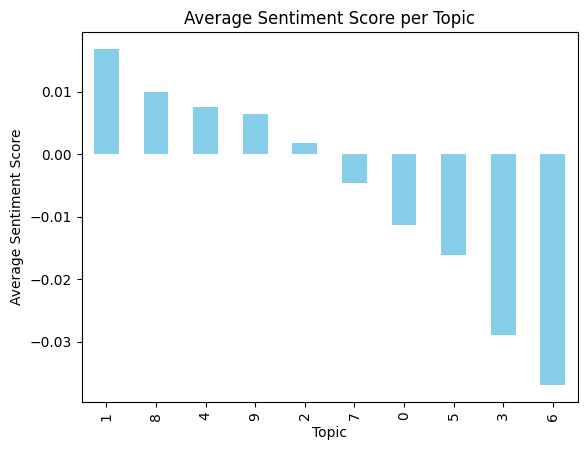

In [84]:
# Next, we calculate the average sentiment score for each topic
# Suppose we already have a column 'Sentiment_Score' in our DataFrame, representing the sentiment score
topic_sentiment = df.groupby('Dominant_Topic')['TextBlob Sentiment'].mean().sort_values(ascending=False)

# Visualize the average sentiment score for each topic
topic_sentiment.plot(kind='bar', color='skyblue')
plt.title('Average Sentiment Score per Topic')
plt.xlabel('Topic')
plt.ylabel('Average Sentiment Score')
plt.show()

N-gram

In [85]:
def get_top_ngram(corpus, n):
    lis=[]
    vec = CountVectorizer(ngram_range = (n,n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis = 0)
    for word,idx in vec.vocabulary_.items():
        lis.append((word, sum_words[0,idx]))
    lis.sort(key = lambda x: x[1], reverse = True)
    return lis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: title={'center': 'Top 20 frequently occured uni-gram'}>

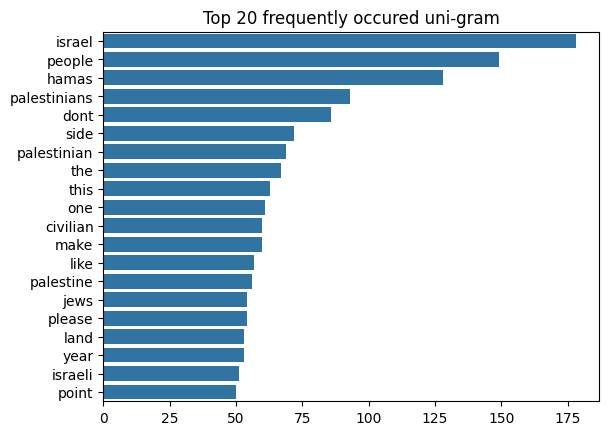

In [86]:
top_n_bigrams=get_top_ngram(df['Processed body'],1)[:20]
x,y=map(list,zip(*top_n_bigrams))
plt.title('Top 20 frequently occured uni-gram')
sns.barplot(x=y,y=x)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: title={'center': 'Top 20 frequently occured bi-grams'}>

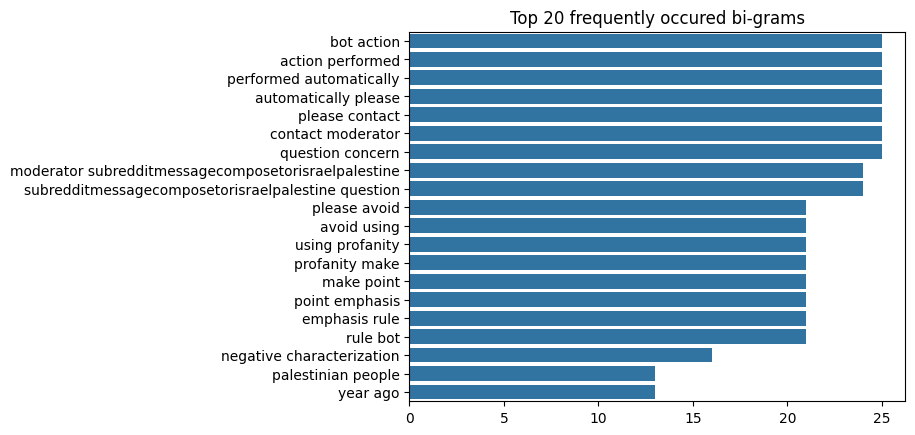

In [87]:
top_n_bigrams=get_top_ngram(df['Processed body'],2)[:20]
x,y=map(list,zip(*top_n_bigrams))
plt.title('Top 20 frequently occured bi-grams')
sns.barplot(x=y,y=x)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: title={'center': 'Top 20 frequently occured tri-grams'}>

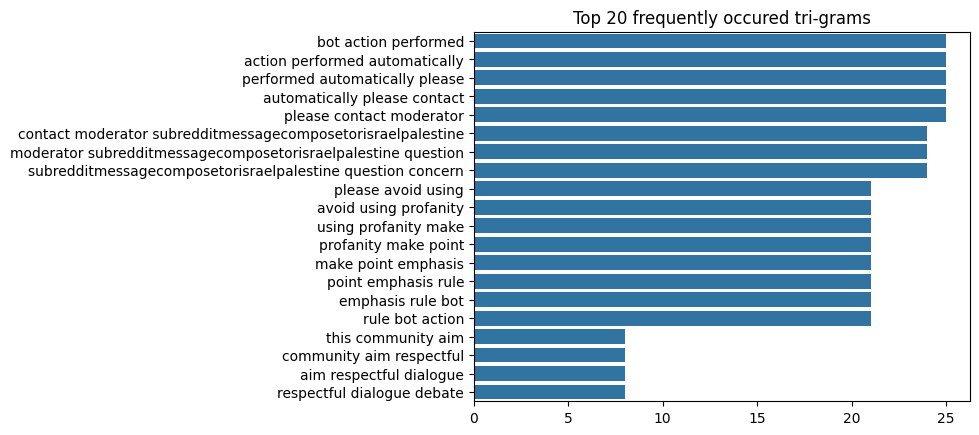

In [88]:
top_n_bigrams=get_top_ngram(df['Processed body'],3)[:20]
x,y=map(list,zip(*top_n_bigrams))
plt.title('Top 20 frequently occured tri-grams')
sns.barplot(x=y,y=x)

In [90]:
# def plot_top_ngrams(sub_df, title, ax):
#     top_ngrams = get_top_ngram(sub_df['Processed body'], 1)[:20]
#     x, y = zip(*top_ngrams)
#     sns.barplot(x=list(y), y=list(x), ax=ax)
#     ax.set_title(title)

# # Set up matplotlib figure and axes
# fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# # Plot for positive sentiment
# positive_posts = df[(df['dataType'] == 'post') & (df['TextBlob Sentiment Category'] == 'positive')]
# plot_top_ngrams(positive_posts, 'Top 20 frequently occurred uni-grams - Positive Posts', axes[0])

# # Plot for neutral sentiment
# negative_posts = df[(df['dataType'] == 'post') & (df['TextBlob Sentiment Category'] == 'neutral')]
# plot_top_ngrams(negative_posts, 'Top 20 frequently occurred uni-grams - Neutral Posts', axes[1])

# # Display the plots
# plt.tight_layout()
# plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [92]:
# def plot_top_ngrams(sub_df, title, ax):
#     top_ngrams = get_top_ngram(sub_df['Processed body'], 1)[:20]
#     x, y = zip(*top_ngrams)
#     sns.barplot(x=list(y), y=list(x), ax=ax)
#     ax.set_title(title)

# # Set up matplotlib figure and axes
# fig, axes = plt.subplots(3, 1, figsize=(10, 8))

# # Plot for positive sentiment
# positive_posts = df[(df['dataType'] == 'comment') & (df['TextBlob Sentiment Category'] == 'positive')]
# plot_top_ngrams(positive_posts, 'Top 20 frequently occurred uni-grams - Positive Comments', axes[0])

# # Plot for neutral sentiment
# negative_posts = df[(df['dataType'] == 'comment') & (df['TextBlob Sentiment Category'] == 'neutral')]
# plot_top_ngrams(negative_posts, 'Top 20 frequently occurred uni-grams - Neutral Comments', axes[1])

# # Plot for negative sentiment
# negative_posts = df[(df['dataType'] == 'comment') & (df['TextBlob Sentiment Category'] == 'negative')]
# plot_top_ngrams(negative_posts, 'Top 20 frequently occurred uni-grams - Negative Comments', axes[2])

# # Display the plots
# plt.tight_layout()
# plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [93]:
# def plot_top_ngrams(sub_df, title, ax):
#     top_ngrams = get_top_ngram(sub_df['Processed body'], 2)[:20]
#     x, y = zip(*top_ngrams)
#     sns.barplot(x=list(y), y=list(x), ax=ax)
#     ax.set_title(title)

# # Set up matplotlib figure and axes
# fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# # Plot for positive sentiment
# positive_posts = df[(df['dataType'] == 'post') & (df['TextBlob Sentiment Category'] == 'positive')]
# plot_top_ngrams(positive_posts, 'Top 20 frequently occurred bi-grams - Positive Posts', axes[0])

# # Plot for neutral sentiment
# negative_posts = df[(df['dataType'] == 'post') & (df['TextBlob Sentiment Category'] == 'neutral')]
# plot_top_ngrams(negative_posts, 'Top 20 frequently occurred bi-grams - Neutral Posts', axes[1])

# # Display the plots
# plt.tight_layout()
# plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# def plot_top_ngrams(sub_df, title, ax):
#     top_ngrams = get_top_ngram(sub_df['Processed body'], 2)[:20]
#     x, y = zip(*top_ngrams)
#     sns.barplot(x=list(y), y=list(x), ax=ax)
#     ax.set_title(title)

# # Set up matplotlib figure and axes
# fig, axes = plt.subplots(3, 1, figsize=(10, 8))

# # Plot for positive sentiment
# positive_posts = df[(df['dataType'] == 'comment') & (df['TextBlob Sentiment Category'] == 'positive')]
# plot_top_ngrams(positive_posts, 'Top 20 frequently occurred bi-grams - Positive Comments', axes[0])

# # Plot for neutral sentiment
# negative_posts = df[(df['dataType'] == 'comment') & (df['TextBlob Sentiment Category'] == 'neutral')]
# plot_top_ngrams(negative_posts, 'Top 20 frequently occurred bi-grams - Neutral Comments', axes[1])

# # Plot for negative sentiment
# negative_posts = df[(df['dataType'] == 'comment') & (df['TextBlob Sentiment Category'] == 'negative')]
# plot_top_ngrams(negative_posts, 'Top 20 frequently occurred bi-grams - Negative Comments', axes[2])

# # Display the plots
# plt.tight_layout()
# plt.show()

In [ ]:
# def plot_top_ngrams(sub_df, title, ax):
#     top_ngrams = get_top_ngram(sub_df['Processed body'], 3)[:20]
#     x, y = zip(*top_ngrams)
#     sns.barplot(x=list(y), y=list(x), ax=ax)
#     ax.set_title(title)

# # Set up matplotlib figure and axes
# fig, axes = plt.subplots(3, 1, figsize=(10, 8))

# # Plot for positive sentiment
# positive_posts = df[(df['dataType'] == 'comment') & (df['TextBlob Sentiment Category'] == 'positive')]
# plot_top_ngrams(positive_posts, 'Top 20 frequently occurred bi-grams - Positive Comments', axes[0])

# # Plot for neutral sentiment
# negative_posts = df[(df['dataType'] == 'comment') & (df['TextBlob Sentiment Category'] == 'neutral')]
# plot_top_ngrams(negative_posts, 'Top 20 frequently occurred bi-grams - Neutral Comments', axes[1])

# # Plot for negative sentiment
# negative_posts = df[(df['dataType'] == 'comment') & (df['TextBlob Sentiment Category'] == 'negative')]
# plot_top_ngrams(negative_posts, 'Top 20 frequently occurred tri-grams - Negative Comments', axes[2])

# # Display the plots
# plt.tight_layout()
# plt.show()

Quantitative Analysis

In [ ]:
# # Calculate correlations using SciPy
# correlation, _ = pearsonr(df['upVotes'], df['TextBlob Sentiment'])
# comments = df[df['dataType'] == 'comment']
# posts = df[df['dataType'] == 'post']
# print('Pearson correlation betweeen Sentiment and upVotes:', correlation)

In [ ]:
comments = df[df['dataType'] == 'comment']
posts = df[df['dataType'] == 'post']

In [ ]:
comments_correlation = comments[['TextBlob Sentiment', 'numberOfreplies', 'upVotes']].corr()
posts_correlation = posts[['TextBlob Sentiment', 'numberOfComments', 'upVotes']].corr()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.heatmap(comments_correlation, annot=True, fmt=".2f", cmap="coolwarm", ax=ax[0])
ax[0].set_title('Comments Correlation Heatmap')

sns.heatmap(posts_correlation, annot=True, fmt=".2f", cmap="coolwarm", ax=ax[1])
ax[1].set_title('Posts Correlation Heatmap')

plt.tight_layout()
plt.show()

Visualisation

In [95]:
# # Trend plots using matplotlib and seaborn
# plt.figure(figsize=(10,5))
# sns.lineplot(data=df, x='createdAt', y='upVotes')
# plt.title('Number of Likes Over Time')
# plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


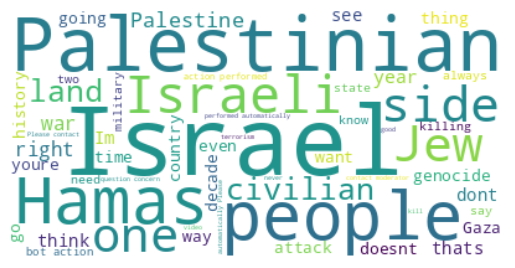

In [96]:
# WordCloud
text = ' '.join(review for review in df['Processed body'])
wordcloud = WordCloud(background_color='white').generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
posts_text = ' '.join(text for text in df[df['dataType'] == 'post']['Processed body'])
wordcloud_posts = WordCloud(background_color='white', max_words=50, contour_width=3, contour_color='steelblue')
wordcloud_posts.generate(posts_text)
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_posts, interpolation='bilinear')
plt.title('WordCloud for Posts')
plt.axis('off')

In [ ]:
comments_text = ' '.join(text for text in df[df['dataType'] == 'comment']['Processed body'])
wordcloud_comments = WordCloud(background_color='white', max_words=50, contour_width=3, contour_color='steelblue')
wordcloud_comments.generate(comments_text)
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_comments, interpolation='bilinear')
plt.title('WordCloud for Comments')
plt.axis('off')